In [1]:
library(ape)
library(sitePath)

Warning message:
"package 'sitePath' was built under R version 3.6.3"


In [2]:
data(h3n2_align)
data(h3n2_tree)

In [3]:
tree <- addMSA(h3n2_tree, alignment = h3n2_align)

In [4]:
paths <- lineagePath(tree, similarity = 0.023)

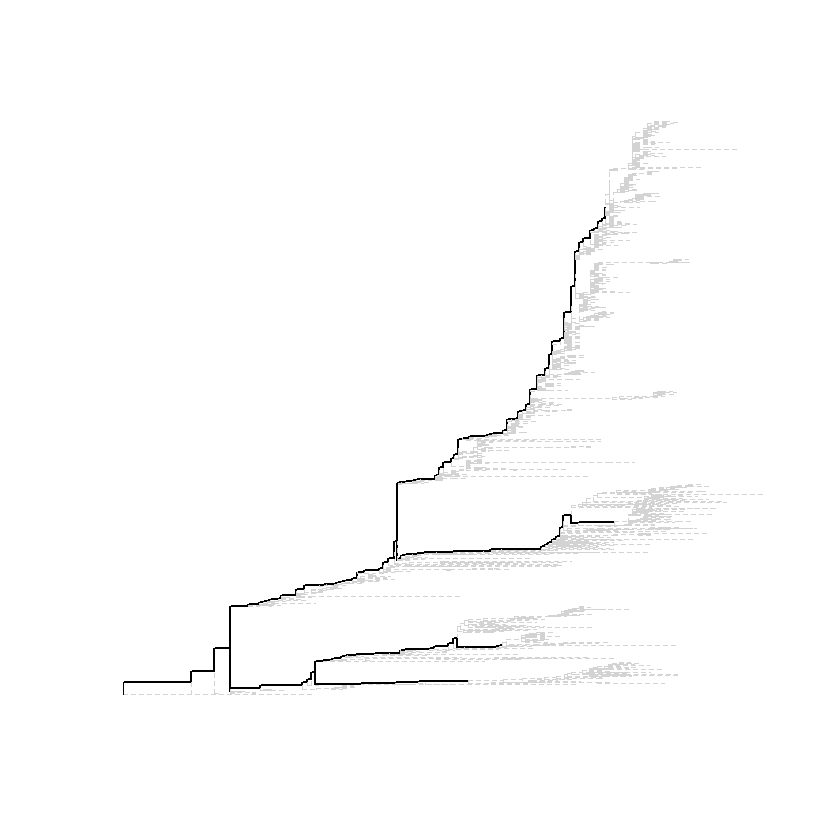

In [5]:
plot(paths)

In [6]:
fixationlineages <- function (paths,
                              minEffectiveSize = NULL,
                              searchDepth = 1,
                              method = c("compare", "insert", "delete"),
                              ...) {
    tree <- attr(paths, "tree")
    nTips <- length(tree[["tip.label"]])
    align <- attr(paths, "align")
    # Generate the site mapping from reference
    reference <- attr(paths, "reference")
    # Decide which miniminzing strategy
    minimizeEntropy <- switch(
        match.arg(method),
        "compare" = sitePath:::minEntropyByComparing,
        "insert" = sitePath:::minEntropyByInserting,
        "delete" = sitePath:::minEntropyByDeleting
    )
    # Get the 'minEffectiveSize' for each fixation
    if (is.null(minEffectiveSize)) {
        minEffectiveSize <- nTips / length(unique(unlist(paths)))
    } else if (!is.numeric(minEffectiveSize)) {
        stop("\"minEffectiveSize\" only accepts numeric")
    }
    minEffectiveSize <- ceiling(minEffectiveSize)
    # Get the 'searchDepth' for heuristic search
    if (searchDepth < 1) {
        stop("\"searchDepth\" should be at least 1")
    } else {
        searchDepth <- ceiling(searchDepth)
    }
    divNodes <- sitePath:::divergentNode(paths)
    nodeAlign <- sitePath:::.tipSeqsAlongPathNodes(
        paths = paths,
        divNodes = divNodes,
        tree = tree,
        align = align
    )
    res <- sitePath:::.findFixationSite(
        paths = paths,
        tree = tree,
        align = align,
        nodeAlign = nodeAlign,
        divNodes = divNodes,
        reference = reference,
        minimizeEntropy = minimizeEntropy,
        minEffectiveSize = minEffectiveSize,
        searchDepth = searchDepth
    )
    attr(res, "paths") <- paths
    attr(res, "reference") <- reference
    class(res) <- "fixationSites"
    return(res)
}

In [7]:
mutations <- fixationlineages(paths, method = "insert")

In [8]:
groupByPath <- lapply(paths, function (p) {
    terminalTips <- sitePath:::.childrenTips(tree, p[length(p)])
    group <- list()
    for (sp in mutations) {
        site <- attr(sp, "site")
        for (mp in sp) {
            tips <- mp[[length(mp)]]
            if (all(terminalTips %in% tips)) {
                toAdd <- lapply(mp, function (tips) {
                    siteChar <- attr(tips, "AA")
                    attributes(tips) <- NULL
                    attr(tips, "site") <- siteChar
                    names(attr(tips, "site")) <- site
                    tips
                })
                group <- c(group, list(toAdd))
            }
        }
    }
    return(group)
})

In [9]:
grouping <- lapply(groupByPath, function (group) {
    res <- group[[1]]
    for (p in group[-1]) {
        for (tips in p) {
            site <- attr(tips, "site")
            # Update grouping for each tips by growing a new list
            newGrouping <- list()
            for (i in seq_along(res)) {
                gp <- res[[i]]
                common <- sort(intersect(tips, gp))
                if (length(common) == 0) {
                    newGrouping <- res[1:i]
                } else if (identical(sort(gp), sort(tips))) {
                    attr(gp, "site") <- c(attr(gp, "site"), site)
                    if (i + 1 <= length(res)) {
                        trailing <- res[(i + 1):length(res)]
                    } else {
                        trailing <- list()
                    }
                    newGrouping <- c(newGrouping, list(gp), trailing)
                    break
                } else {
                    if (identical(sort(gp), common)) {
                        # The new coming tips includes the current group
                        # The extra tips stay for the next loop
                        tips <- setdiff(tips, gp)
                        # Update the SNP site info for the current group
                        attr(gp, "site") <- c(attr(gp, "site"), site)
                        newGrouping <- c(newGrouping, list(gp))
                    } else if (identical(sort(tips), common)) {
                        # The new coming tips are included in the group (they are used up at this point)
                        separate <- setdiff(gp, tips)
                        attributes(separate) <- attributes(gp)
                        attr(tips, "site") <- c(attr(gp, "site"), site)
                        if (i + 1 <= length(res)) {
                            trailing <- res[(i + 1):length(res)]
                        } else {
                            trailing <- list()
                        }
                        newGrouping <- c(newGrouping, list(tips), list(separate), trailing)
                        # Go for the next new coming tips
                        break
                    } else {
                        stop("Something's not right")
                    }
                }
            }
            # The new coming tips are used up and update the grouping
            res <- newGrouping
        }
    }
    return(res)
})

In [11]:
groupingSNP <- lapply(grouping, function (gp) {
    res <- list()
    refSites <- attr(gp[[1]], "site")
    for (tips in gp) {
        sites <- attr(tips, "site")
        attr(tips, "site") <- sites[which(vapply(
            X = seq_along(refSites),
            FUN = function (i) {
                if (refSites[i] != sites[i]) {
                    return(TRUE)
                }
                return(FALSE)
            }, 
            FUN.VALUE = logical(1)
        ))]
        res <- c(res, list(tips))
    }
    return(res)
})

In [12]:
print(groupingSNP)

[[1]]
[[1]][[1]]
 [1] 1889 1890    1 1888 1881 1882 1886 1887 1883 1884 1885 1879 1880
attr(,"site")
named character(0)

[[1]][[2]]
[1] 1875 1876 1877 1878
attr(,"site")
161 179 191 216 366 
"P" "T" "D" "Q" "I" 

[[1]][[3]]
 [1] 1602 1603 1614 1604 1605 1606 1607 1613 1608 1609 1610 1611 1612
attr(,"site")
 15  68 161 165 179 183 191 193 216 220 263 366 
"A" "K" "P" "G" "T" "Q" "D" "S" "Q" "K" "V" "I" 

[[1]][[4]]
[1] 1615 1616
attr(,"site")
 15  68  71 161 165 179 191 208 216 263 366 
"A" "K" "N" "P" "G" "T" "D" "Q" "Q" "V" "I" 

[[1]][[5]]
[1] 1617
attr(,"site")
 15  17  68  71 161 165 179 191 208 216 263 297 366 
"A" "G" "K" "N" "P" "G" "T" "D" "Q" "Q" "V" "I" "I" 

[[1]][[6]]
[1] 1618
attr(,"site")
 15  17  68  71 161 165 179 191 207 208 216 263 294 297 366 
"A" "G" "K" "N" "P" "G" "T" "D" "N" "Q" "Q" "V" "D" "I" "I" 

[[1]][[7]]
[1] 1798
attr(,"site")
 15  17  68  71 101 161 165 179 191 207 208 216 263 294 297 366 
"A" "G" "K" "N" "T" "P" "G" "T" "D" "N" "Q" "Q" "V" "D" "I" "I" 

